## Accessing TerraClimate data with the Planetary Computer STAC API

[TerraClimate](http://www.climatologylab.org/terraclimate.html) is a dataset of monthly climate and climatic water balance for global terrestrial surfaces from 1958-2019. These data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data. All data have monthly temporal resolution and a ~4-km (1/24th degree) spatial resolution. The data cover the period from 1958-2019.

This example will show you how temperature has increased over the past 60 years across the globe.

### Environment setup

In [238]:
import warnings
import os
from scipy import spatial
from datetime import datetime
warnings.filterwarnings("ignore")

### Data access

https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate is a STAC Collection with links to all the metadata about this dataset. We'll load it with [PySTAC](https://pystac.readthedocs.io/en/latest/).

In [3]:
import pystac

url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate"
collection = pystac.read_file(url)
collection

<Collection id=terraclimate>

The collection contains assets, which are links to the root of a Zarr store, which can be opened with xarray.

In [4]:
asset = collection.assets["zarr-https"]
asset

<Asset href=https://cpdataeuwest.blob.core.windows.net/cpdata/raw/terraclimate/4000m/raster.zarr>

In [5]:
import fsspec
import xarray as xr

store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


We'll process the data in parallel using [Dask](https://dask.org).

In [6]:
pwd()

'/home/jovyan/final-project-team-ando-shravan-final_proj/scripts'

In [7]:
# from dask_gateway import GatewayCluster
%run helper.ipynb
setup_dask_cluster()

<Client: 'tls://10.244.62.31:8786' processes=0 threads=0, memory=0 B>
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.f4368d798bd44c1a95e847fa0bf95d70/status


### Subset based on lat long of interest

In [8]:
# lon_point_list = [-85.9, -82, -82, -85.9]
# lat_point_list = [11.3, 11.3, 8, 8]

# ds.isel(lat=slice(-86, -82), lon=slice(8, 11.3))

cr=ds.sel(lat=slice(11.3, 8), lon=slice(-85.9,-82))

In [9]:
# cr['tmax']
type(cr)

xarray.core.dataset.Dataset

In [10]:
sum(cr.tmax.isnull())

<xarray.DataArray 'tmax' (lat: 79, lon: 94)>
dask.array<add, shape=(79, 94), dtype=int64, chunksize=(79, 94), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 11.27 11.23 11.19 11.15 ... 8.146 8.104 8.063 8.021
  * lon      (lon) float64 -85.9 -85.85 -85.81 -85.77 ... -82.1 -82.06 -82.02

The link printed out above can be opened in a new tab or the [Dask labextension](https://github.com/dask/dask-labextension). See [Scale with Dask](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/) for more on using Dask, and how to access the Dashboard.

### Analyze and plot global temperature

We can quickly plot a map of one of the variables. In this case, we are downsampling (coarsening) the dataset for easier plotting.

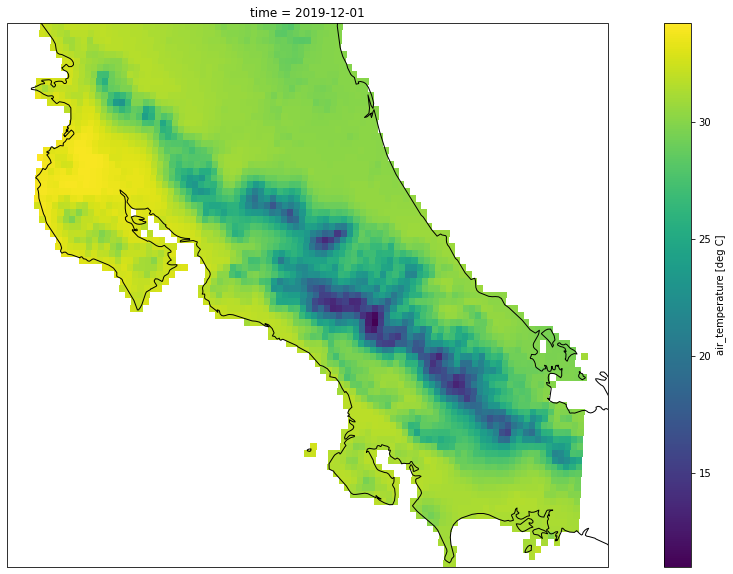

In [11]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

average_max_temp = cr.isel(time=-1)["tmax"].load()

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(projection=ccrs.Robinson()))

average_max_temp.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines();

In [12]:
type(cr)

xarray.core.dataset.Dataset

Let's see how temperature has changed over the observational record, when averaged across the entire domain. Since we'll do some other calculations below we'll also add `.load()` to execute the command instead of specifying it lazily.  Note that there are some data quality issues before 1965 so we'll start our analysis there.

In [13]:
temperature = (
    cr["tmax"].sel(time=slice("2011", None)).mean(dim=["lat", "lon"]).persist()
)

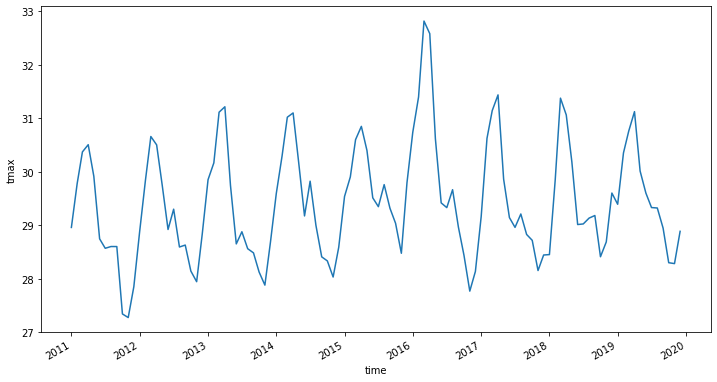

In [14]:
temperature.plot(figsize=(12, 6));

With all the seasonal fluctuations (from summer and winter) though, it can be hard to see any obvious trends. So let's try grouping by year and plotting that timeseries.

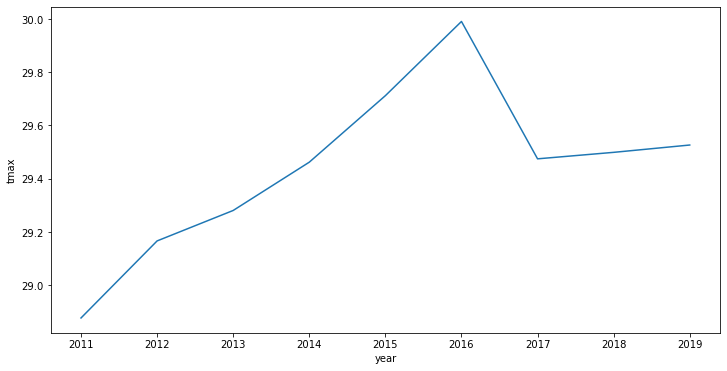

In [15]:
temperature.groupby("time.year").mean().plot(figsize=(12, 6));

Now the increase in temperature is obvious, even when averaged across the entire domain.

### High res filteration 

In [16]:
import geopandas
import cartopy

countries = geopandas.read_file(
    "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
)

In [17]:
cr_polygon=countries[countries['ISO_A2']=='CR']

In [18]:
cr_polygon['geometry'] = cr_polygon['geometry'].set_crs("EPSG:4326")

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [19]:
import geopandas as gpd
from shapely.geometry import Polygon
import shapely as sh


lon_point_list = [-85.9, -82, -82, -85.9]
lat_point_list = [11.3, 11.3, 8, 8]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
crs = 'epsg:4326'
bounding_box = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])

<AxesSubplot:>

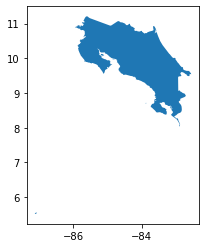

In [20]:
# cr_core = gpd.overlay(cr_polygon, bounding_box, how='intersection')
cr_core=cr_polygon.copy()
cr_core.plot()

In [21]:
type(cr_core), cr_core.head()

(geopandas.geodataframe.GeoDataFrame,
          ADMIN ISO_A3 ISO_A2  \
 53  Costa Rica    CRI     CR   
 
                                              geometry  
 53  MULTIPOLYGON (((-87.09903 5.51602, -87.11767 5...  )

In [22]:
cr

<xarray.Dataset>
Dimensions:                 (time: 744, lat: 79, lon: 94, crs: 1)
Coordinates:
  * crs                     (crs) int16 3
  * lat                     (lat) float64 11.27 11.23 11.19 ... 8.063 8.021
  * lon                     (lon) float64 -85.9 -85.85 -85.81 ... -82.06 -82.02
  * time                    (time) datetime64[ns] 1958-01-01 ... 2019-12-01
Data variables: (12/18)
    aet                     (time, lat, lon) float32 dask.array<chunksize=(12, 79, 94), meta=np.ndarray>
    def                     (time, lat, lon) float32 dask.array<chunksize=(12, 79, 94), meta=np.ndarray>
    pdsi                    (time, lat, lon) float32 dask.array<chunksize=(12, 79, 94), meta=np.ndarray>
    pet                     (time, lat, lon) float32 dask.array<chunksize=(12, 79, 94), meta=np.ndarray>
    ppt                     (time, lat, lon) float32 dask.array<chunksize=(12, 79, 94), meta=np.ndarray>
    ppt_station_influence   (time, lat, lon) float32 dask.array<chunksize=(12, 79, 94), meta=np.ndarray>
    ...                      ...
    tmin                    (time, lat, lon) float32 dask.array<chunksize=(12, 79, 94), meta=np.ndarray>
    tmin_station_influence  (time, lat, lon) float32 dask.array<chunksize=(12, 79, 94), meta=np.ndarray>
    vap                     (time, lat, lon) float32 dask.array<chunksize=(12, 79, 94), meta=np.ndarray>
    vap_station_influence   (time, lat, lon) float32 dask.array<chunksize=(12, 79, 94), meta=np.ndarray>
    vpd                     (time, lat, lon) float32 dask.array<chunksize=(12, 79, 94), meta=np.ndarray>
    ws                      (time, lat, lon) float32 dask.array<chunksize=(12, 79, 94), meta=np.ndarray>

In [23]:
list_data_vars=[i for i in cr.data_vars]

In [24]:
# Converting xarray dataframe (points) to geopandas dataframe
# def 
param=list_data_vars
xarr_df=cr

xarr = xarr_df[param]
df = xarr.to_dask_dataframe().reset_index(drop=True)

In [25]:
len(xarr_df)

18

### NA analysis
NA observed in ~52% data variables

In [26]:
df.isna().sum().compute()

time                            0
lat                             0
lon                             0
aet                       2857704
def                       2857704
pdsi                      2857704
pet                       2857704
ppt                       2857704
ppt_station_influence           0
q                         2857704
soil                      2857704
srad                      2857704
swe                       2857704
tmax                      2857704
tmax_station_influence          0
tmin                      2857704
tmin_station_influence          0
vap                       2857704
vap_station_influence           0
vpd                       2858745
ws                        2857704
dtype: int64

In [27]:
df_na=df[df.tmax.isna()].reset_index(drop=True)

In [28]:
df_na.head()

,time,lat,lon,aet,def,pdsi,pet,ppt,ppt_station_influence,q,...,srad,swe,tmax,tmax_station_influence,tmin,tmin_station_influence,vap,vap_station_influence,vpd,ws
0,1958-01-01,11.270833,-83.812500,NaN,NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,NaN,2.0,NaN,NaN
1,1958-01-01,11.270833,-83.770833,NaN,NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,NaN,2.0,NaN,NaN
2,1958-01-01,11.270833,-83.729167,NaN,NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,NaN,2.0,NaN,NaN
3,1958-01-01,11.270833,-83.687500,NaN,NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,NaN,2.0,NaN,NaN
4,1958-01-01,11.270833,-83.645833,NaN,NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,NaN,2.0,NaN,NaN


In [29]:
 df_na.isna().sum().compute()

time                            0
lat                             0
lon                             0
aet                       2857704
def                       2857704
pdsi                      2857704
pet                       2857704
ppt                       2857704
ppt_station_influence           0
q                         2857704
soil                      2857704
srad                      2857704
swe                       2857704
tmax                      2857704
tmax_station_influence          0
tmin                      2857704
tmin_station_influence          0
vap                       2857704
vap_station_influence           0
vpd                       2857704
ws                        2857704
dtype: int64

In [30]:
len(df)

5524944

In [31]:
2857704/5524944

0.5172367357931592

#### NA observed as "tmax_station_influence", "tmin_station_influence" and "vap_station_influence" variables are populated when required data variables aren't

Examining if the timeseries data is consistent in the non-NA dataset (all month-year data populated, and no month is left out)

In [32]:
df=df[~(df['tmax'].isna())].reset_index()

In [33]:
len(df)

2667240

In [34]:
5524944-2857704

2667240

In [35]:
df.columns

Index(['index', 'time', 'lat', 'lon', 'aet', 'def', 'pdsi', 'pet', 'ppt',
       'ppt_station_influence', 'q', 'soil', 'srad', 'swe', 'tmax',
       'tmax_station_influence', 'tmin', 'tmin_station_influence', 'vap',
       'vap_station_influence', 'vpd', 'ws'],
      dtype='object')

In [36]:
df.time.min().compute(), df.time.max().compute()

(Timestamp('1958-01-01 00:00:00'), Timestamp('2019-12-01 00:00:00'))

In [37]:
start=datetime(1958,1,1)
end=datetime(2019,12,1)

12*(end.year-start.year)+(end.month-start.month)

743

In [38]:
len(df[['lat','lon']].drop_duplicates())

3585

In [39]:
744*3585

2667240

In [40]:
2667240-744*3585

0

All lat-long coordinates have same number of time stamp!

In [41]:
lat_long_time_agg=df.groupby(['lat','lon']).time.nunique().reset_index().compute()

In [42]:
lat_long_time_agg.head()

,lat,lon,time
0,8.020833,-82.895833,744
1,8.020833,-82.854167,744
2,8.062500,-82.895833,744
3,8.062500,-82.854167,744
4,8.062500,-82.312500,744


In [43]:
lat_long_time_agg.time.unique()

array([744])

### Filtering data for only the latest 5 years

In [44]:
df.columns

Index(['index', 'time', 'lat', 'lon', 'aet', 'def', 'pdsi', 'pet', 'ppt',
       'ppt_station_influence', 'q', 'soil', 'srad', 'swe', 'tmax',
       'tmax_station_influence', 'tmin', 'tmin_station_influence', 'vap',
       'vap_station_influence', 'vpd', 'ws'],
      dtype='object')

In [45]:
df_recent=df[df['time']>datetime(2014, 12,1)].reset_index(drop=True)

In [46]:
len(df_recent)

215100

### Getting the average metrics and sd

In [47]:
df_agg = df_recent[['pdsi','ppt','soil', 'srad', 'tmax', 'tmin', 'vap','lat','lon']].groupby(['lat','lon']).agg([np.mean, np.std]).compute()

In [48]:
df_agg.reset_index(inplace=True)
df_agg.head()

lat        lon      pdsi                   ppt              \
                            mean       std        mean         std   
0  8.020833 -82.895833 -1.303333  4.725587  254.850000  213.776437   
1  8.020833 -82.854167 -1.485000  4.824437  253.250000  204.072982   
2  8.062500 -82.895833 -1.291666  4.717379  252.450000  206.924892   
3  8.062500 -82.854167 -1.198333  4.736282  250.250000  210.473609   
4  8.062500 -82.312500 -0.551666  5.098936  228.883333  194.858056   

         soil                   srad                  tmax            \
         mean        std        mean        std       mean       std   
0  137.566667  53.791310  215.916667  30.264503  31.731669  1.592719   
1  137.316667  53.200771  216.200000  29.854336  31.795001  1.600053   
2  133.416667  52.502558  214.166667  28.976437  31.661668  1.586516   
3  133.500000  52.924795  214.033333  29.472193  31.748336  1.583011   
4  136.083333  59.458375  218.083333  30.499921  32.231669  0.733791   

        tmin                 vap            
        mean       std      mean       std  
0  21.650002  0.825527  2.991000  0.158851  
1  21.770001  0.823663  3.002667  0.160460  
2  21.563334  0.826885  2.981000  0.157970  
3  21.725002  0.818115  2.996666  0.160316  
4  23.101668  0.538162  2.974833  0.158709

In [49]:
len(df_agg)

3585

In [50]:
df_agg.columns=['lat', 'lon', 'pdsi_mean', 'pdsi_std', 'ppt_mean', 'ppt_std', 'soil_mean', 'soil_std', 'srd_mean', 
                'srad_std', 'tmax_mean', 'tmax_std', 'tmin_mean', 'tmin_std', 'vap_mean', 'vap_std']

In [51]:
df_agg.head()

,lat,lon,pdsi_mean,pdsi_std,ppt_mean,ppt_std,soil_mean,soil_std,srd_mean,srad_std,tmax_mean,tmax_std,tmin_mean,tmin_std,vap_mean,vap_std
0,8.020833,-82.895833,-1.303333,4.725587,254.850000,213.776437,137.566667,53.791310,215.916667,30.264503,31.731669,1.592719,21.650002,0.825527,2.991000,0.158851
1,8.020833,-82.854167,-1.485000,4.824437,253.250000,204.072982,137.316667,53.200771,216.200000,29.854336,31.795001,1.600053,21.770001,0.823663,3.002667,0.160460
2,8.062500,-82.895833,-1.291666,4.717379,252.450000,206.924892,133.416667,52.502558,214.166667,28.976437,31.661668,1.586516,21.563334,0.826885,2.981000,0.157970
3,8.062500,-82.854167,-1.198333,4.736282,250.250000,210.473609,133.500000,52.924795,214.033333,29.472193,31.748336,1.583011,21.725002,0.818115,2.996666,0.160316
4,8.062500,-82.312500,-0.551666,5.098936,228.883333,194.858056,136.083333,59.458375,218.083333,30.499921,32.231669,0.733791,23.101668,0.538162,2.974833,0.158709


### Converting dataframe to geopandas df

In [52]:
data_vars_interest=['pdsi_mean', 'pdsi_std', 'ppt_mean', 'ppt_std', 'soil_mean', 'soil_std', 'srd_mean', 
                'srad_std', 'tmax_mean', 'tmax_std', 'tmin_mean', 'tmin_std', 'vap_mean', 'vap_std']

gdf = gpd.GeoDataFrame(
    df_agg[data_vars_interest], geometry=gpd.points_from_xy(df_agg.lon,df_agg.lat))

In [53]:
#setting crs
gdf=gdf.set_crs(epsg=4326, inplace=True)

<AxesSubplot:>

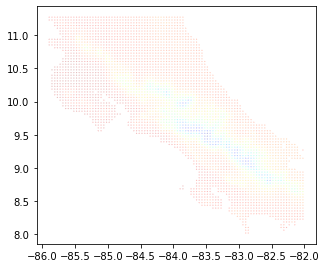

In [54]:
gdf.plot(markersize=0.01, figsize=(5,5), column='tmax_mean', cmap='jet')

AxesSubplot(0.125,0.172839;0.775x0.659321)


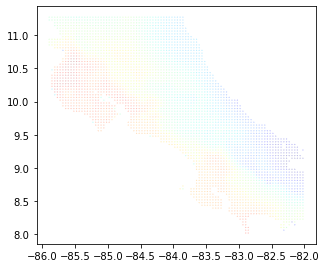

In [55]:
print(gdf.plot(markersize=0.01, figsize=(5,5), column='tmax_std', cmap='jet'))

Data variable: pdsi_mean


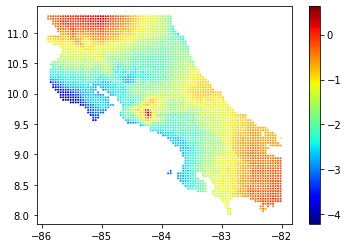

Data variable: pdsi_std


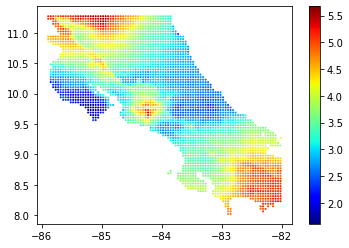

Data variable: ppt_mean


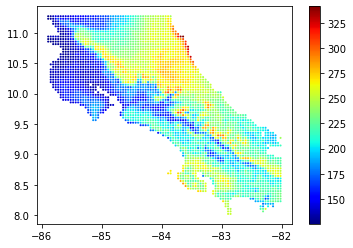

Data variable: ppt_std


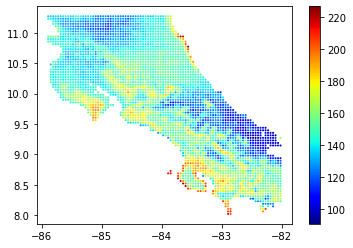

Data variable: soil_mean


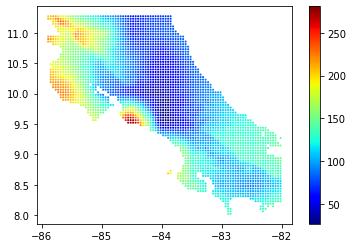

Data variable: soil_std


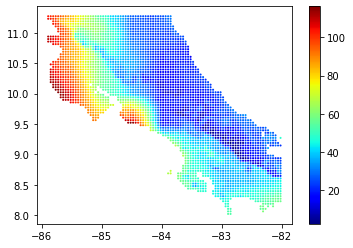

Data variable: srd_mean


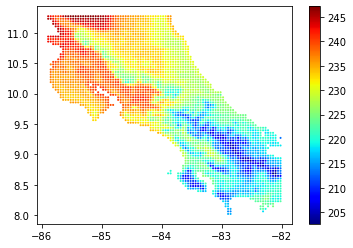

Data variable: srad_std


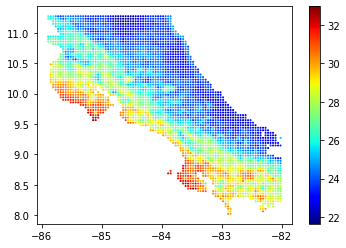

Data variable: tmax_mean


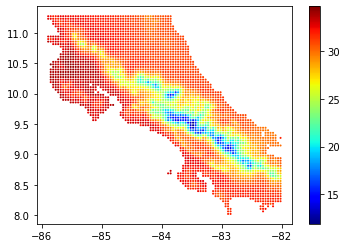

Data variable: tmax_std


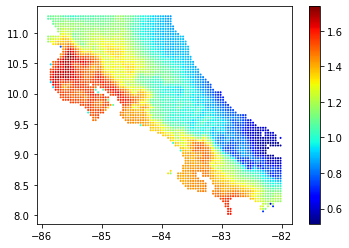

Data variable: tmin_mean


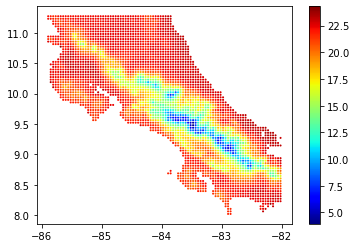

Data variable: tmin_std


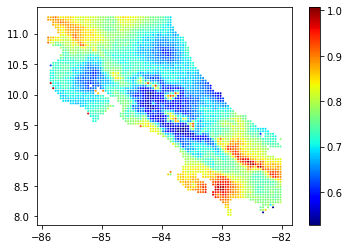

Data variable: vap_mean


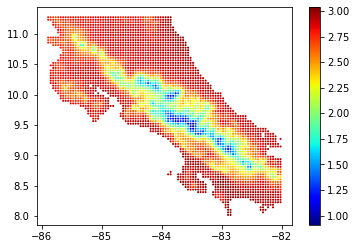

Data variable: vap_std


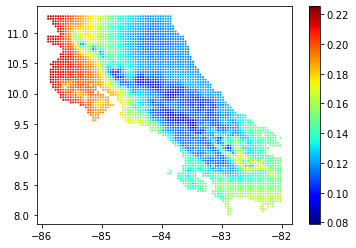

In [65]:
import matplotlib.pyplot as plt
for i in data_vars_interest:
    print("Data variable:", i)
    gdf.plot(ax=ax, markersize=1, figsize=(6,6), column=i, cmap='jet', legend=True)
    plt.show()

In [67]:
#Checking if the coordinate reference system is same
gdf.crs==cr_core.crs

True

In [68]:
#Filtering out "data for Costa Rica based on the high resolution polygon
cr_corr_vars = gpd.overlay(gdf, cr_core, how='intersection')

In [69]:
len(cr_corr_vars) #2431

2431

<AxesSubplot:>

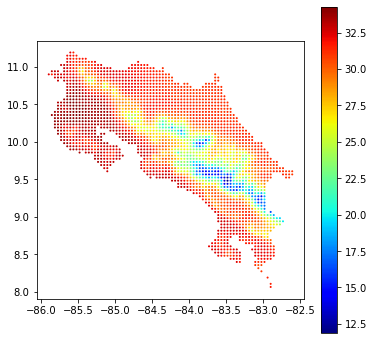

In [70]:
#Plotting Costa Rica
cr_corr_vars.plot(markersize=1, figsize=(6,6), column='tmax_mean', cmap='jet', legend=True)

### Generate arbitarary gridpoints

In [83]:
cr_core.bounds

,minx,miny,maxx,maxy
53,-87.117665,5.515082,-82.562837,11.209937


In [85]:
a=[0.01,0.02]
a[1]

0.02

In [202]:
#gpd_polygon: geopandas polygon (used to get boundaries)
#grid size: in lat-long ([0.01,0.02]
from shapely.geometry import Point

def grid_point_generator(gpd_polygon,grid_size):   
    south=gpd_polygon.total_bounds[1]
    west=gpd_polygon.total_bounds[0]
    north=gpd_polygon.total_bounds[3]
    east=gpd_polygon.total_bounds[2]
    x=west
    summary=[]
    while x <= east:
        y=south
        while y<= north:
            summary.append([Point(x, y)])
            y=y+grid_size[0]
        x=x+grid_size[1]
    summary_df=gpd.GeoDataFrame(summary, columns=['geometry'], crs='epsg:4326')
    return summary_df

In [232]:
grid_points=grid_point_generator(cr_core,[0.01,0.01])

### Nearest Point

In [241]:
gdf.reset_index(drop=True, inplace=True)
grid_points.reset_index(drop=True, inplace=True)

tree = spatial.cKDTree(np.c_[np.array(gdf.geometry.x), np.array(gdf.geometry.y)])
d,i=tree.query(np.c_[np.array(grid_points.geometry.x), np.array(grid_points.geometry.y)],1)

#i is the array containing the index of the nearest sparse grid points corresponding to each dense grid point
#d is the distance corresponding distance

In [246]:
gdf.reset_index(inplace=True)
gdf.head()

,index,pdsi_mean,pdsi_std,ppt_mean,ppt_std,soil_mean,soil_std,srd_mean,srad_std,tmax_mean,tmax_std,tmin_mean,tmin_std,vap_mean,vap_std,geometry
0,0,-1.303333,4.725587,254.850000,213.776437,137.566667,53.791310,215.916667,30.264503,31.731669,1.592719,21.650002,0.825527,2.991000,0.158851,POINT (-82.89583 8.02083)
1,1,-1.485000,4.824437,253.250000,204.072982,137.316667,53.200771,216.200000,29.854336,31.795001,1.600053,21.770001,0.823663,3.002667,0.160460,POINT (-82.85417 8.02083)
2,2,-1.291666,4.717379,252.450000,206.924892,133.416667,52.502558,214.166667,28.976437,31.661668,1.586516,21.563334,0.826885,2.981000,0.157970,POINT (-82.89583 8.06250)
3,3,-1.198333,4.736282,250.250000,210.473609,133.500000,52.924795,214.033333,29.472193,31.748336,1.583011,21.725002,0.818115,2.996666,0.160316,POINT (-82.85417 8.06250)
4,4,-0.551666,5.098936,228.883333,194.858056,136.083333,59.458375,218.083333,30.499921,32.231669,0.733791,23.101668,0.538162,2.974833,0.158709,POINT (-82.31250 8.06250)


In [247]:
closest=pd.DataFrame(i, columns=['grid_index'])
closest['index']=closest['grid_index'].apply(lambda x: gdf.iloc[x]['index'])
#closest is the dataframe containing mapping of indexes AND geometry of nearest sparse grid points for corresponding dense grid point 

In [253]:
closest_all_vars=closest.merge(gdf, on='index', how='inner')
closest_all_vars.head()

,grid_index,index,pdsi_mean,pdsi_std,ppt_mean,ppt_std,soil_mean,soil_std,srd_mean,srad_std,tmax_mean,tmax_std,tmin_mean,tmin_std,vap_mean,vap_std,geometry
0,1246,1246,-3.626666,2.411264,183.1,185.334305,176.916667,91.798287,232.833333,32.882534,33.023334,1.486946,21.541669,0.718795,2.857,0.190451,POINT (-85.14583 9.56250)
1,1246,1246,-3.626666,2.411264,183.1,185.334305,176.916667,91.798287,232.833333,32.882534,33.023334,1.486946,21.541669,0.718795,2.857,0.190451,POINT (-85.14583 9.56250)
2,1246,1246,-3.626666,2.411264,183.1,185.334305,176.916667,91.798287,232.833333,32.882534,33.023334,1.486946,21.541669,0.718795,2.857,0.190451,POINT (-85.14583 9.56250)
3,1246,1246,-3.626666,2.411264,183.1,185.334305,176.916667,91.798287,232.833333,32.882534,33.023334,1.486946,21.541669,0.718795,2.857,0.190451,POINT (-85.14583 9.56250)
4,1246,1246,-3.626666,2.411264,183.1,185.334305,176.916667,91.798287,232.833333,32.882534,33.023334,1.486946,21.541669,0.718795,2.857,0.190451,POINT (-85.14583 9.56250)


In [256]:
closest_all_vars.rename(columns={'geometry': 'sparse_geometry'}, inplace=True)

In [257]:
#merging the closest_all_vars (which contains dense index + data vars of the nearest sparse grid point)
terra_cr=pd.concat([grid_points, closest_all_vars], axis=1)
terra_cr.head()

,geometry,grid_index,index,pdsi_mean,pdsi_std,ppt_mean,ppt_std,soil_mean,soil_std,srd_mean,srad_std,tmax_mean,tmax_std,tmin_mean,tmin_std,vap_mean,vap_std,sparse_geometry
0,POINT (-87.11767 5.51508),1246,1246,-3.626666,2.411264,183.1,185.334305,176.916667,91.798287,232.833333,32.882534,33.023334,1.486946,21.541669,0.718795,2.857,0.190451,POINT (-85.14583 9.56250)
1,POINT (-87.11767 5.52508),1246,1246,-3.626666,2.411264,183.1,185.334305,176.916667,91.798287,232.833333,32.882534,33.023334,1.486946,21.541669,0.718795,2.857,0.190451,POINT (-85.14583 9.56250)
2,POINT (-87.11767 5.53508),1246,1246,-3.626666,2.411264,183.1,185.334305,176.916667,91.798287,232.833333,32.882534,33.023334,1.486946,21.541669,0.718795,2.857,0.190451,POINT (-85.14583 9.56250)
3,POINT (-87.11767 5.54508),1246,1246,-3.626666,2.411264,183.1,185.334305,176.916667,91.798287,232.833333,32.882534,33.023334,1.486946,21.541669,0.718795,2.857,0.190451,POINT (-85.14583 9.56250)
4,POINT (-87.11767 5.55508),1246,1246,-3.626666,2.411264,183.1,185.334305,176.916667,91.798287,232.833333,32.882534,33.023334,1.486946,21.541669,0.718795,2.857,0.190451,POINT (-85.14583 9.56250)


In [266]:
import random
test=terra_cr[['geometry', 'sparse_geometry']]
test['lon_diff']=test['geometry'].x-test['sparse_geometry'].x
test['lat_diff']=test['geometry'].y-test['sparse_geometry'].y
random.seed(42)
test.iloc[random.sample(range(len(test)), 20)]

,geometry,sparse_geometry,lon_diff,lat_diff
167621,POINT (-84.17767 5.92508),POINT (-82.89583 8.02083),-1.281832,-2.095751
29184,POINT (-86.60767 6.65508),POINT (-85.14583 9.56250),-1.461832,-2.907418
6556,POINT (-87.00767 8.37508),POINT (-85.14583 9.56250),-1.861832,-1.187418
194393,POINT (-83.70767 5.74508),POINT (-84.56250 10.81250),0.854835,-5.067418
72097,POINT (-85.85767 8.28508),POINT (-85.89583 10.93750),0.038168,-2.652418
64196,POINT (-85.99767 9.07508),POINT (-85.85417 10.35417),-0.143499,-1.279085
58513,POINT (-86.09767 9.24508),POINT (-85.85417 10.18750),-0.243499,-0.942418
36579,POINT (-86.47767 6.50508),POINT (-85.64583 9.89583),-0.831832,-3.390751
193061,POINT (-83.73767 9.52508),POINT (-84.60417 10.77083),0.866501,-1.245751
26868,POINT (-86.64767 6.29508),POINT (-85.14583 9.56250),-1.501832,-3.267418


In [268]:
terra_test_tiles = gpd.clip(terra_cr, cr_core)

<AxesSubplot:>

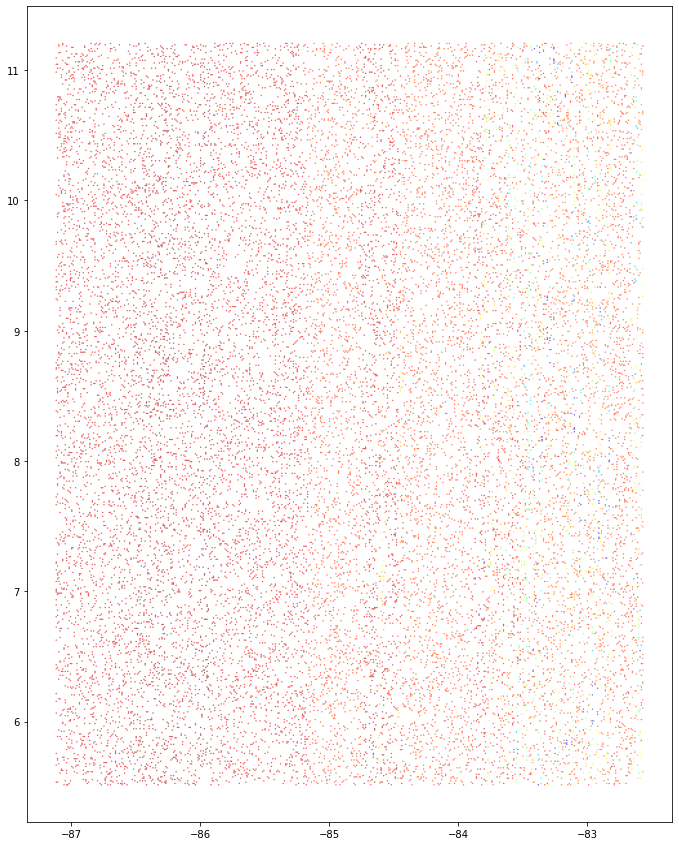

In [276]:
terra_cr.iloc[random.sample(range(len(terra_cr)),20000)].plot(markersize=0.1, column='tmax_mean', cmap='jet', figsize=(15,15))